In [18]:
import sys
import yaml
import tempfile
import os
import subprocess
from pathlib import Path
sys.path.append("/home/iwsatlas1/bhuth/exatrkx/gnn4itk/commonframework")

In [19]:
import torch
import torch_geometric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps

In [20]:
from gnn4itk_cf.stages.data_reading import ActsReader
from gnn4itk_cf.stages.graph_construction.models.utils import build_edges

In [21]:
def cantor_pairing(a):
    a = np.sort(a, axis=0)
    return a[1] + ((a[0] + a[1]) * (a[0] + a[1] + 1)) // 2

In [22]:
def effpur(true, pred):
    cantor_true = cantor_pairing(true)
    cantor_pred = cantor_pairing(pred)
    cantor_intersection = np.intersect1d(cantor_true, cantor_pred)

    return {
        "eff": len(cantor_intersection)
        / len(cantor_true),  # if len(cantor_true) > 0 else 0,
        "pur": len(cantor_intersection)
        / len(cantor_pred),  # if len(cantor_pred) > 0 else 0,
    }

In [57]:
graph

Data(hit_id=[48958], cell_val=[48958], eta=[48958], y=[48958], lx=[48958], cell_count=[48958], x=[48958], phi=[48958], ly=[48958], z=[48958], r=[48958], region=[48958], track_edges=[2, 34353], nhits=[34353], radius=[34353], particle_id=[34353], particle_eta=[34353], pt=[34353], config=[1], event_id='000000001')

In [58]:
graph.particle_id[ (graph.nhits > 2) & (graph.pt > 0.5) ].shape

torch.Size([9471])

In [59]:
target_edges = graph.track_edges[: , (graph.nhits > 2) & (graph.pt > 0.5) ]
target_edges.shape

torch.Size([2, 9471])

In [61]:
DEVICE="cuda:2"

In [62]:
x = torch.stack([
    graph.r/1000.0,
    graph.phi/3.14,
    graph.z/3000.0,
    graph.cell_count,
    graph.cell_val,
    graph.lx,
    graph.ly
]).T.to(torch.float32).to(DEVICE)

In [63]:
embeddingModel = torch.jit.load("../torchscript/500_geant4_pseudo_vertex_smear/embedding.pt").to(DEVICE)

In [64]:
emb = embeddingModel(x).to(DEVICE)
emb.shape

torch.Size([48958, 8])

In [65]:
edge_index = build_edges(emb, emb, r_max=0.2, k_max=600, backend="")
edge_index.shape

torch.Size([2, 1073194])

In [66]:
effpur(target_edges, edge_index)

TypeError: can't convert cuda:2 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [12]:
filterModel = torch.jit.load("../torchscript/500_geant4_pseudo_vertex_smear/filter.pt").to(DEVICE)

In [13]:
filter_scores = torch.sigmoid(filterModel(x[:,:3], edge_index))
filter_scores.shape

torch.Size([1073192])

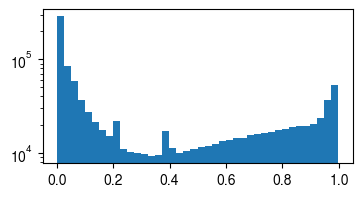

In [95]:
plt.figure(figsize=(4,2))
_ = plt.hist(filter_scores.detach().cpu().numpy().flatten(), bins=40)
_ = plt.yscale('log')

In [15]:
filter_edges = edge_index[:, filter_scores > 0.5 ]
filter_edges.shape

torch.Size([2, 381210])

In [78]:
effpur(target_edges, filter_edges)

{'eff': 0.9302080033787351, 'pur': 0.02311062144224968}

In [96]:
gnnModel = torch.jit.load("../torchscript/500_geant4_pseudo_vertex_smear/gnn.pt").to(DEVICE)

In [97]:
gnn_scores = torch.sigmoid(gnnModel(x[:,:3], torch.hstack([filter_edges, filter_edges.flip(0)])))
gnn_scores.shape

torch.Size([762420])

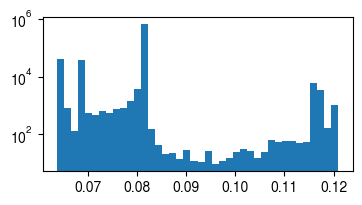

In [98]:
plt.figure(figsize=(4,2))
_ = plt.hist(gnn_scores.detach().cpu().numpy().flatten(), bins=40)
_ = plt.yscale('log')

In [59]:
final_edges = filter_edges[:, gnn_scores[:len(gnn_scores)//2] > 0.5]
final_edges.shape

torch.Size([2, 18012])

In [79]:
effpur(target_edges, final_edges)

{'eff': 0.6069052898321191, 'pur': 0.31912058627581613}

In [60]:
sparse_matrix = torch_geometric.utils.to_scipy_sparse_matrix(final_edges)
_, labels = sps.csgraph.connected_components(sparse_matrix, directed=False, return_labels=True)

In [61]:
unique_labels, counts = np.unique(labels, return_counts=True)

In [62]:
sum(counts > 2)

2667

In [63]:
unique_labels = unique_labels[counts > 2]

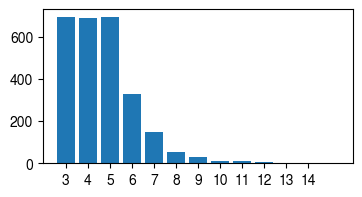

In [64]:
plt.figure(figsize=(4,2))
_ = plt.bar(*np.unique(counts[ counts > 2 ], return_counts=True))
_ = plt.xticks(np.arange(3, max(counts)))

### States of trained event

In [103]:
base_dir = Path("/home/iwsatlas1/bhuth/exatrkx/gnn4itk/runs/ODD-pixel-geometric-geant-pseudo/event500-weight-increase/tmp")

In [111]:
torch.load(base_dir / "metric_learning/testset/event['000000009'].pyg").edge_index.shape

torch.Size([2, 849725])

In [127]:
def plot_scores(file, title):
    testdata = torch.load(file)
    target_edges = testdata.track_edges[: , (testdata.nhits > 2) & (testdata.pt > 0.5) ]
    print("target:",effpur(target_edges, testdata.edge_index[:, testdata.scores > 0.5]))
    print("   all:",effpur(testdata.track_edges, testdata.edge_index[:, testdata.scores > 0.5]))
    plt.figure(figsize=(4,2))
    plt.title(f"{title}: {len(testdata.scores.detach().cpu().numpy())} edges")
    plt.hist(testdata.scores.detach().cpu().numpy(), bins=40)
    plt.yscale('log')

target: {'eff': 0.953052408509251, 'pur': 0.03849876861887767}
   all: {'eff': 0.5918527222875049, 'pur': 0.0845734943567186}


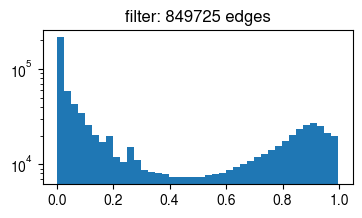

In [128]:
plot_scores(base_dir / "filter/testset/event[['000000009']].pyg", "filter")

target: {'eff': 0.8651886869345505, 'pur': 0.4577996291025143}
   all: {'eff': 0.49014999654385843, 'pur': 0.917453745633329}


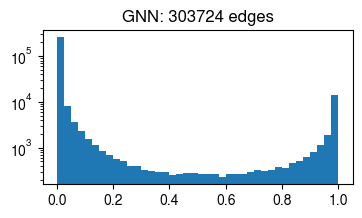

In [129]:
plot_scores(base_dir / "gnn/testset/event[[['000000009']]].pyg", "GNN")